In [191]:
import pandas as pd
import numpy as np
import re
import string
import missingno as msno
import nltk
from textblob import TextBlob

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')
from nltk.corpus import stopwords

import snowballstemmer

stemmer = snowballstemmer.stemmer('english')

nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

import matplotlib.pyplot as plt
# import plotly.express as px
import seaborn as sns



[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Daniel\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Daniel\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Daniel\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     C:\Users\Daniel\AppData\Roaming\nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\Daniel\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Daniel\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexi

# Data Preparation and Sentiment Analysis

# EDA

In [192]:
# data = pd.read_csv('data/www.porkbun.com - Trustpilot.csv', encoding='utf-8')
data = pd.read_csv('data/www.apple.com - Trustpilot.csv', encoding='utf-8')
data.head()


,Unnamed: 0,site,date,stars,title,text,location
0,0,www.apple.com,2023-01-13T23:24:23.000Z,1,"""The customer is not a moron. She's your wife....",The apple app. store earns 30% from the applic...,BE
1,1,www.apple.com,2023-01-13T16:40:56.000Z,1,IPhone 11 is garbage,I bought an iPhone 11 a year and a half ago. T...,CA
2,2,www.apple.com,2023-01-13T07:42:28.000Z,1,Ordered an apple gift card - horrible situation,I ordered an apple gift card which should arri...,MT
3,3,www.apple.com,2023-01-11T03:19:30.000Z,5,"Love my iPhone 14 Pro, Apple Watch Ultra, & Ma...","Upgraded last year to a MacBook Pro, Apple Wat...",US
4,4,www.apple.com,2023-01-13T15:24:48.000Z,1,No phone and no refund,I ordered a new iPhone from apple.com on 11/21...,CY


In [193]:
data.shape

(5629, 7)

In [194]:
data.nunique()

Unnamed: 0    5629
site             1
date          5629
stars            5
title         5370
text          5624
location        93
dtype: int64

In [195]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5629 entries, 0 to 5628
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  5629 non-null   int64 
 1   site        5629 non-null   object
 2   date        5629 non-null   object
 3   stars       5629 non-null   int64 
 4   title       5629 non-null   object
 5   text        5629 non-null   object
 6   location    5629 non-null   object
dtypes: int64(2), object(5)
memory usage: 308.0+ KB


<AxesSubplot: >

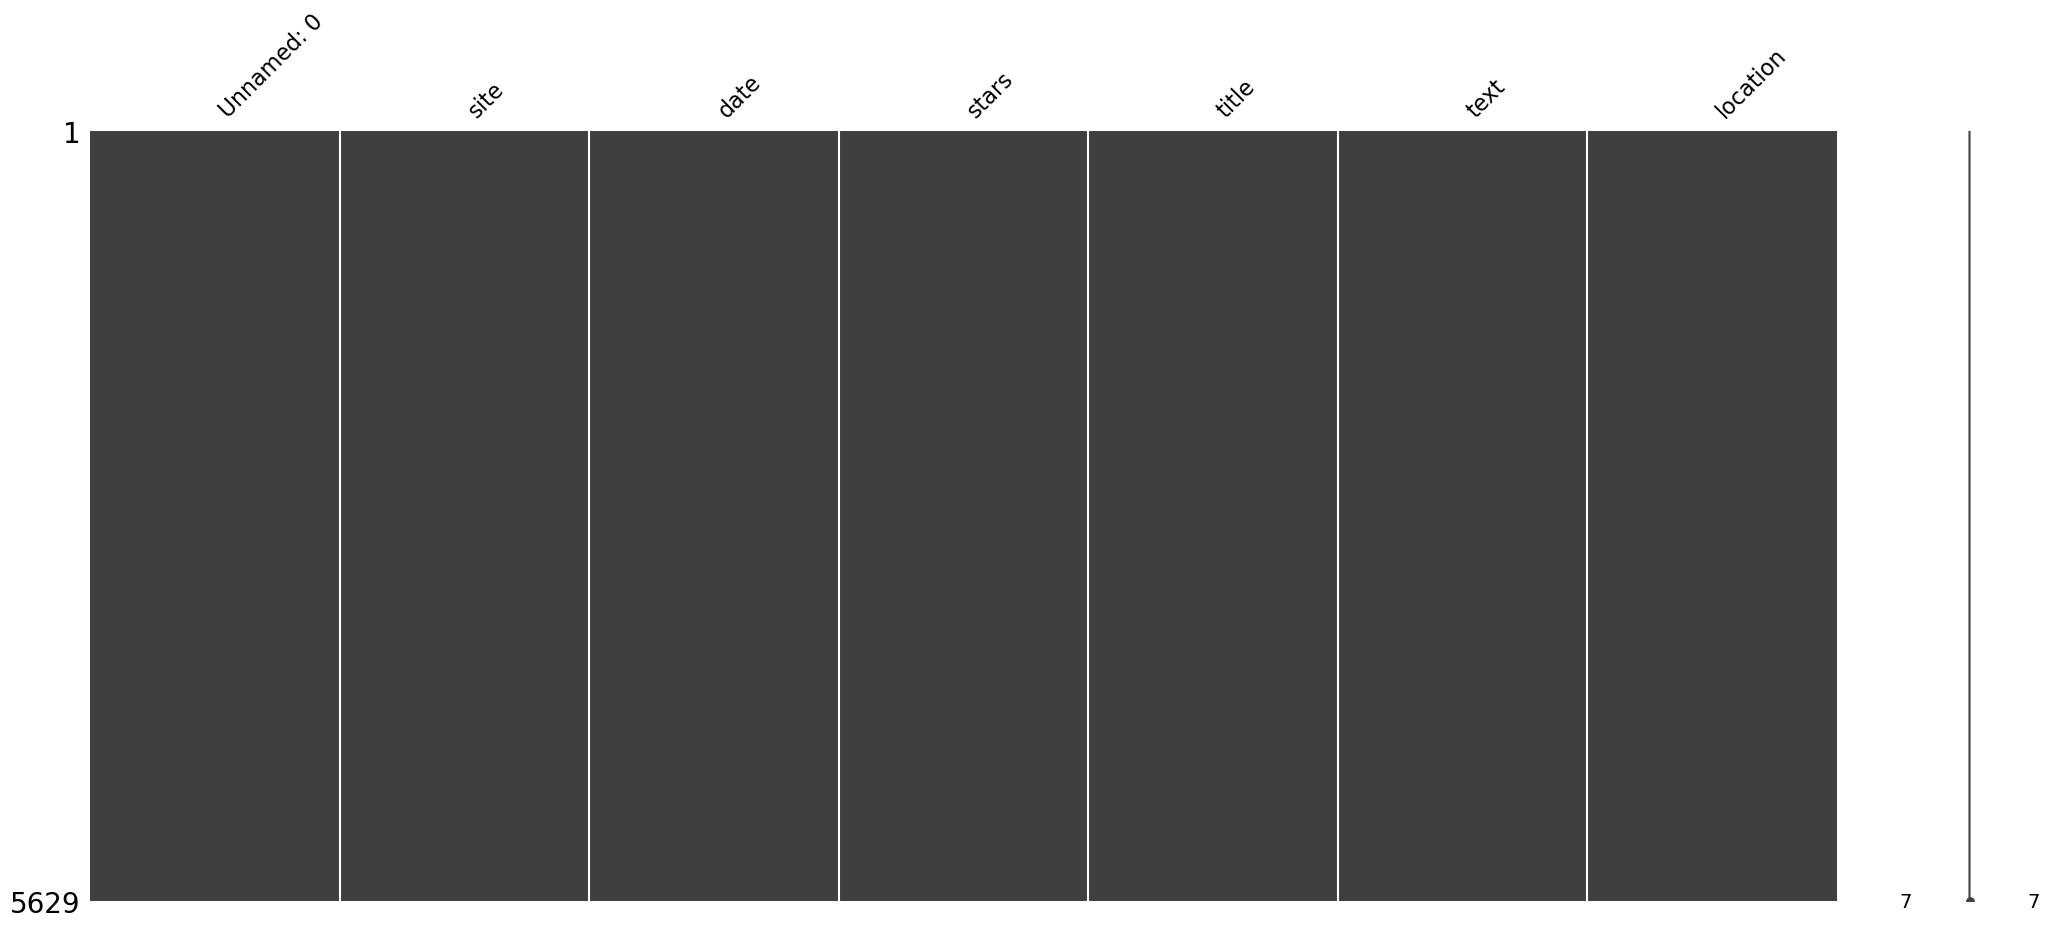

In [196]:
msno.matrix(data)

In [197]:
data.drop(['Unnamed: 0', 'date', 'location'], inplace=True, axis=1)
data.head()

,site,stars,title,text
0,www.apple.com,1,"""The customer is not a moron. She's your wife....",The apple app. store earns 30% from the applic...
1,www.apple.com,1,IPhone 11 is garbage,I bought an iPhone 11 a year and a half ago. T...
2,www.apple.com,1,Ordered an apple gift card - horrible situation,I ordered an apple gift card which should arri...
3,www.apple.com,5,"Love my iPhone 14 Pro, Apple Watch Ultra, & Ma...","Upgraded last year to a MacBook Pro, Apple Wat..."
4,www.apple.com,1,No phone and no refund,I ordered a new iPhone from apple.com on 11/21...


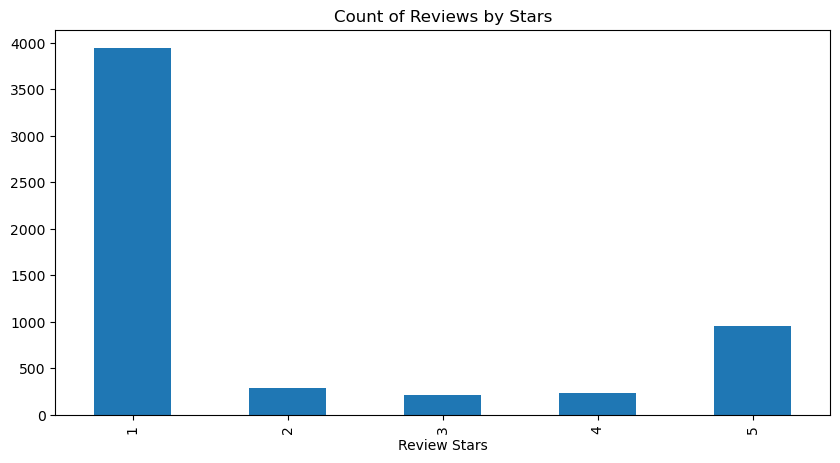

In [198]:
ax = data['stars'].value_counts().sort_index() \
    .plot(kind='bar',
          title='Count of Reviews by Stars',
          figsize=(10, 5))
ax.set_xlabel('Review Stars')
plt.show()

## Cleaning

In [199]:
nltk.download('vader_lexicon')
stp_words = stopwords.words('english')


def clean_text(text):
    # No data
    if text.startswith('Date of experience:'):
        return np.nan

    text = text.lower()

    text = re.sub('\\\\', ' ', text)  # removal of excaped escape

    # replace single quotes
    text = re.sub(r"\[\'", '["', text)
    text = re.sub(r"\']", '"]', text)

    text = re.sub(r"(\', )", '", ', text)
    text = re.sub(r"(, \')", ', "', text)

    #  remove links
    text = re.sub(r"https?:\/\/[a-zA-Z0-9,.\/?#:\-_.~&]*", ' ', text)

    # remove emojis | source: https://stackoverflow.com/a/49146722
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)

    # remove stopwords, numbers and punctuation
    text = ' '.join(word.strip(string.punctuation) for word in text.split() if
                    (word not in stp_words) or (not any(c.isdigit() for c in word)))

    text = re.sub(r'\s+', ' ', text)  #removal of multiple spaces

    # stem text
    text = " ".join(stemmer.stemWords(text.split()))

    # tokens = nltk.word_tokenize(text)
    # tagged = nltk.pos_tag(tokens)
    # entities = nltk.chunk.ne_chunk(tagged)

    if len(text) == 0:
        return np.nan

    return text

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Daniel\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [200]:
# data['title_clean'] = data['title'].apply(clean_text)
data['text_clean'] = data['text'].apply(clean_text)

In [201]:
# print(data["title_clean"].isna().sum())
print(data["text_clean"].isna().sum())

135


In [202]:
# drop empty columns after preprocessing
data.dropna(inplace=True)
data.shape

(5494, 5)

In [203]:
# print(data["title_clean"].isna().sum())
print(data["text_clean"].isna().sum())

0


### Rating - sentiment analysis mapping
- 1 -> -1 - -.75
- 2 -> -.75 - .-25
- 3 -> -.25 - .25
- 4 -> .25 - .75
- 5 -> .75 - 1

negative: 1,2 -> -1
neutral: 0 -> 0
positiv: 4,5 -> 1

In [204]:
# data.loc[data['stars'] <= 2, 'sentiment'] = -1
# data.loc[data['stars'] == 3, 'sentiment'] = 0
# data.loc[data['stars'] >= 4, 'sentiment'] = 1

In [205]:
# data['sentiment'].value_counts()

# Sentiment Analysis

## VADER

In [206]:
sid_vader = SentimentIntensityAnalyzer()

In [207]:
# data['title_sid_vader'] = data['title_clean'].apply(lambda content: sid_vader.polarity_scores(content))
data['text_sid_vader'] = data['text_clean'].apply(lambda content: sid_vader.polarity_scores(content))

# data = pd.concat([data.drop(['title_sid_vader'], axis=1), data['title_sid_vader'].apply(pd.Series)], axis=1)
# data = pd.concat([data.drop(['text_sid_vader'], axis=1), data['text_sid_vader'].apply(lambda value:
#     pd.Series(value).rename(index={'neg': 'title_sid_vader_neg', 'neu': 'title_sid_vader_neu',
#                             'pos': 'title_sid_vader_pos',
#                             'compound': 'title_sid_vader_compound'}))], axis=1)
data = pd.concat([data.drop(['text_sid_vader'], axis=1), data['text_sid_vader'].apply(lambda value:
    pd.Series(value).rename(index={'neg': 'text_sid_vader_neg', 'neu': 'text_sid_vader_neu',
                            'pos': 'text_sid_vader_pos',
                            'compound': 'text_sid_vader_compound'}))], axis=1)

### Plot VADER results

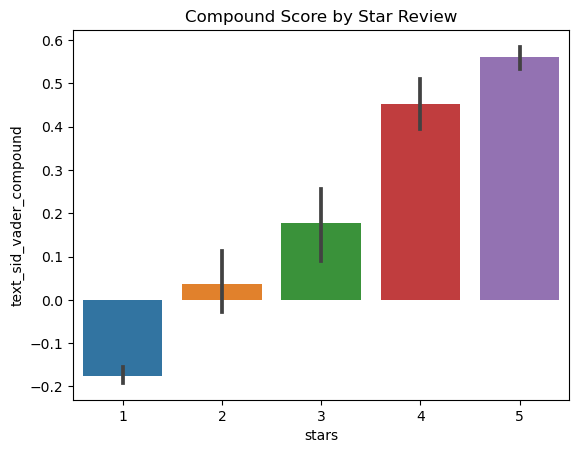

In [208]:
ax = sns.barplot(data=data, x='stars', y='text_sid_vader_compound')
ax.set_title('Compound Score by Star Review')
plt.show()

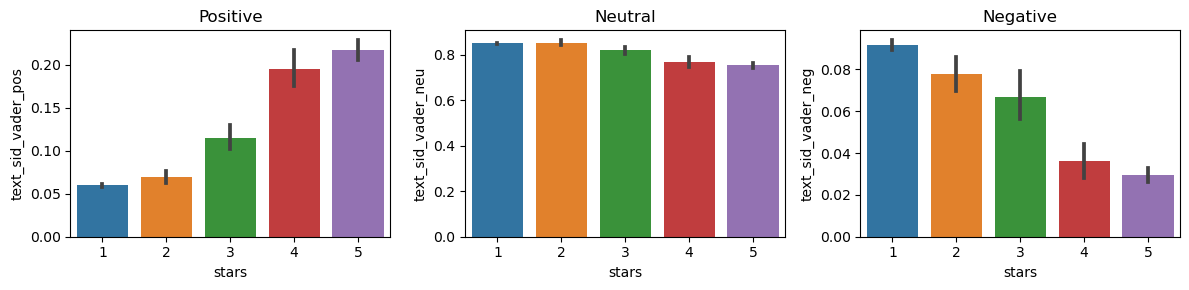

In [209]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3))
sns.barplot(data=data, x='stars', y='text_sid_vader_pos', ax=axs[0])
sns.barplot(data=data, x='stars', y='text_sid_vader_neu', ax=axs[1])
sns.barplot(data=data, x='stars', y='text_sid_vader_neg', ax=axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.tight_layout()
plt.show()

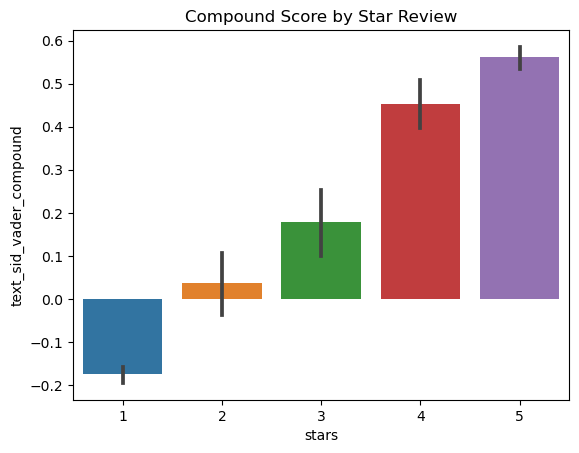

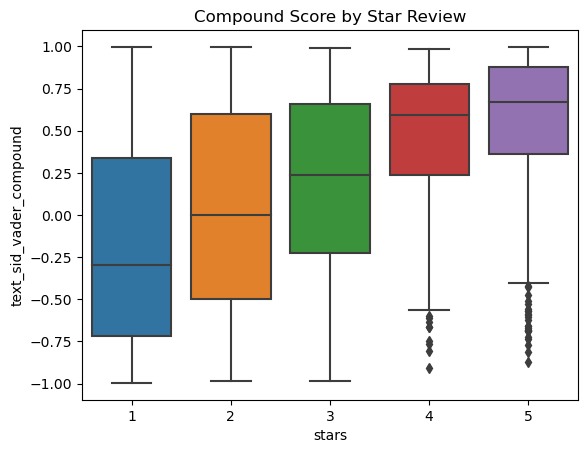

,count,mean,std,min,25%,50%,75%,max
stars,,,,,,,,
1,3883.0,-0.175370,0.606638,-0.9965,-0.718400,-0.29600,0.339550,0.9941
2,280.0,0.036486,0.599723,-0.9839,-0.496975,0.00000,0.601075,0.9961
3,201.0,0.177966,0.555039,-0.9824,-0.226300,0.23820,0.659700,0.9918
4,222.0,0.452192,0.438309,-0.9060,0.238200,0.59445,0.778100,0.9829
5,908.0,0.561216,0.402662,-0.8699,0.361200,0.67050,0.880700,0.9969


In [210]:
ax = sns.barplot(data=data, x='stars', y='text_sid_vader_compound')
ax.set_title('Compound Score by Star Review')
plt.show()

# Use the data from above to create a boxplot
ax = sns.boxplot(data=data, x='stars', y='text_sid_vader_compound')
ax.set_title('Compound Score by Star Review')
plt.show()


# What is the average compound score range for each star rating?
data.groupby('stars')['text_sid_vader_compound'].describe()


## TextBlob

In [211]:
# data['title_sid_textblob_polarity '] = data['title_clean'].apply(lambda content: TextBlob(content).sentiment.polarity)
data['text_sid_textblob_polarity'] = data['text_clean'].apply(lambda content: TextBlob(content).sentiment.polarity)


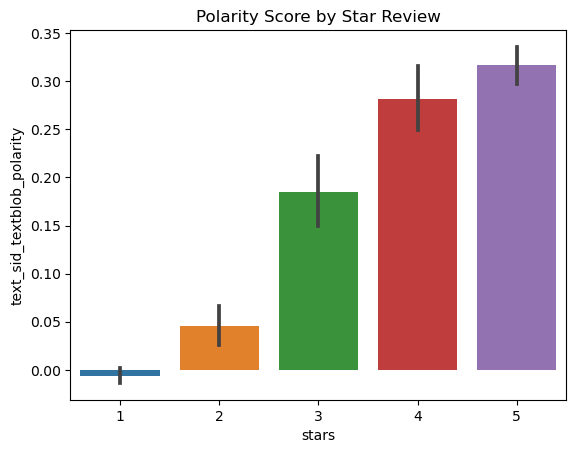

In [212]:
ax = sns.barplot(data=data, x='stars', y='text_sid_textblob_polarity')
ax.set_title('Polarity Score by Star Review')
plt.show()

In [213]:
# Rating - sentiment analysis mapping
# 1 -1 - -.75
# 2 -.75 - .-25
# 3 -.25 - .25
# 4 .25 - .75
# 5 .75 - 1
# interpretation der daten
# abgrenzung der daten
# regressionsmodell zur abgrenzung

In [214]:
# data.to_csv('data_cleaned_apple.csv')